In [1]:
from huggingface_hub import hf_hub_download
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import pickle 
import os

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from hyperopt import hp, tpe, fmin, Trials
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

from preprocessing.utils import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
!set HF_HUB_DISABLE_SYMLINKS_WARNING=true

In [3]:
REPO_ID = "inria-soda/tabular-benchmark"
clf_cat = [
    # 'albert.csv', 
   # 'compas-two-years.csv', 
   # 'covertype.csv', 
   # 'default-of-credit-card-clients.csv',
   'electricity.csv',
   # 'eye_movements.csv',
   # 'road-safety.csv'
]

clf_num = [
    'Bioresponse.csv',
    'Diabetes130US.csv',
    'Higgs.csv',
    'MagicTelescope.csv',
    'MiniBooNE.csv',
    'bank-marketing.csv',
    'california.csv',
    'covertype.csv',
    'credit.csv',
    'default-of-credit-card-clients.csv',
    'electricity.csv',
    'eye_movements.csv',
    'heloc.csv',
    'house_16H.csv',
    'jannis.csv',
    'pol.csv'
]

reg_cat = [
    'Airlines_DepDelay_1M.csv',
    'Allstate_Claims_Severity.csv',
    'Bike_Sharing_Demand.csv',
    'Brazilian houses.csv',
    'Mercedes_Benz_Greener_Manufacturing.csv',
    'SGEMM_GPU_kernel_performance.csv',
    'abalone.csv',
    'analcatdata_supreme.csv',
    'delays_zurich_transport.csv',
    'diamonds.csv',
    'house_sales.csv',
    'medical_charges.csv',
    'nyc-taxi-green-dec-2016.csv',
    'particulate-matter-ukair-2017.csv',
    'seattlecrime6.csv',
    'topo_2_1.csv',
    'visualizing_soil.csv'
]

reg_num = [
    'Ailerons.csv',
    'Bike_Sharing_Demand.csv',
    'Brazilian houses.csv',
    'MiamiHousing2016.csv',
    'abalone.csv',
    'cpu_act.csv',
    'delays_zurich_transport.csv',
    'diamonds.csv',
    'elevators.csv',
    'house_16H.csv',
    'house_sales.csv',
    'houses.csv',
    'medical_charges.csv',
    'nyc-taxi-green-dec-2016.csv',
    'pol.csv',
    'sulfur.csv',
    'superconduct.csv',
    'wine_quality.csv',
    'yprop_4_1.csv'
]

In [5]:
def sample_hpt_from_space(space, n_samples = 100) :
    return [sample(space) for _ in range(n_samples)]

In [9]:
hyperparameter_space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'n_estimators': scope.int(hp.loguniform('n_estimators', np.log(9.5), np.log(3000.5))),
    'max_depth': hp.choice('max_depth', [None, 2, 3, 4]),
    'min_samples_split': hp.choice('min_samples_split', [2, 3]),
    'min_samples_leaf': scope.int(hp.loguniform('min_samples_leaf', np.log(1.5), np.log(50.5))),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_features': hp.choice('max_features', ['sqrt', 'sqrt', 'log2', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    'min_impurity_decrease': hp.choice('min_impurity_decrease', [0.0, 0.01, 0.02, 0.05])
}

# Generate 100 samples from the hyperparameter space
samples = [sample(hyperparameter_space) for _ in range(100)]

# Display the samples
for i, s in enumerate(samples):
    if i > 5 :
        break
    print(f"Sample {i+1}: {s}")
    

Sample 1: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'max_features': 0.6, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 22}
Sample 2: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 0.6, 'min_impurity_decrease': 0.02, 'min_samples_leaf': 26, 'min_samples_split': 2, 'n_estimators': 254}
Sample 3: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_features': 0.3, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
Sample 4: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 0.2, 'min_impurity_decrease': 0.05, 'min_samples_leaf': 48, 'min_samples_split': 2, 'n_estimators': 32}
Sample 5: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 22, 'min_samples_split': 3, 'n_estimators': 1615}
Sample 6: {'bootstrap': True, 'criterion': 'gini', 'ma

In [16]:
df = pd.read_csv(
    hf_hub_download(repo_id=REPO_ID, filename=f'clf_cat/{clf_cat[0]}', repo_type="dataset")
)

# Split and preprocess the data
X, y = df.iloc[:, :-1], df.iloc[:, -1]
X, y = preprocess_data(X, y, isCategorical=True)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y, isCategorical=True)

random_forest_hyperparameter_space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'n_estimators': scope.int(hp.loguniform('n_estimators', np.log(9.5), np.log(3000.5))),
    'max_depth': hp.choice('max_depth', [None, 2, 3, 4]),
    'min_samples_split': hp.choice('min_samples_split', [2, 3]),
    'min_samples_leaf': scope.int(hp.loguniform('min_samples_leaf', np.log(1.5), np.log(50.5))),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_features': hp.choice('max_features', ['sqrt', 'sqrt', 'log2', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    'min_impurity_decrease': hp.choice('min_impurity_decrease', [0.0, 0.01, 0.02, 0.05])
}

n_samples = 2
random_forest_hpt_samples = sample_hpt_from_space(random_forest_hyperparameter_space, n_samples)

# Define the objective function
def objective_function(trial_index):
    hyperparameters = random_forest_hpt_samples[trial_index]
    model = RandomForestClassifier(**hyperparameters)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_val)
    score = -accuracy_score(y_val, y_predict)
    return score

# Wrap the objective function to pass the trial index
def wrapped_objective_function(trial):
    trial_index = trial['index']
    return objective_function(trial_index)

# Define the search space for the trial index
trial_index_space = hp.choice('index', range(n_samples))

# Use hyperopt to optimize the objective function
trials = Trials()
best_trial = fmin(wrapped_objective_function, {'index': trial_index_space}, algo=tpe.suggest, max_evals=n_samples, trials=trials)

# Extract the best trial index
best_trial_index = best_trial['index']

# Retrieve the best hyperparameters
best_hyperparameters = random_forest_hpt_samples[best_trial_index]
print("Best hyperparameters:", best_hyperparameters)

Removed 0 rows with missing values on 58252 rows
Removed 0 columns with missing values on 31 columns
Removed 0 rows with missing values on 58252 rows
Removed 7 columns with pseudo-categorical values on 31 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
100%|█████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.94s/trial, best loss: -0.6316291491797024]
Best hyperparameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'max_features': 0.1, 'min_impurity_decrease': 0.02, 'min_samples_leaf': 30, 'min_samples_split': 2, 'n_estimators': 86}


In [42]:
trials.best_trial['result']['loss']

-0.6316291491797024

In [19]:
for i, trial in enumerate(trials.trials):
    print(f"Iteration {i+1}: Loss = {trial['result']['loss']}, Hyperparameters = {random_forest_hpt_samples[trial['misc']['vals']['index'][0]]}")


Iteration 1: Loss = -0.6316291491797024, Hyperparameters = {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'max_features': 0.1, 'min_impurity_decrease': 0.02, 'min_samples_leaf': 30, 'min_samples_split': 2, 'n_estimators': 86}
Iteration 2: Loss = -0.6316291491797024, Hyperparameters = {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'max_features': 0.1, 'min_impurity_decrease': 0.02, 'min_samples_leaf': 30, 'min_samples_split': 2, 'n_estimators': 86}


In [38]:
np.array([np.random.permutation(100) for _ in range(15)])

array([[28,  8, 53, ..., 12, 83, 92],
       [16, 67, 99, ..., 34, 88, 64],
       [40, 61, 10, ..., 52, 15, 56],
       ...,
       [86,  6, 39, ..., 59, 76, 45],
       [85, 64,  8, ..., 26, 79, 15],
       [68, 75, 72, ..., 51, 18, 27]])

In [7]:
if not os.path.exists('gradient-boosting-results') :
    os.makedirs('gradient-boosting-results')

if not os.path.exists('random-forest-results') :
    os.makedirs('random-forest-results')
    
if not os.path.exists('xgboost-results') :
    os.makedirs('xgboost-results')

np.random.seed(42)
n_iterations = 20
n_shuffles = 3
random_shuffle_indices = np.array([np.random.permutation(n_iterations) for _ in range(n_shuffles)])

clf_cat_random_forest_scores = np.zeros((n_shuffles, n_iterations))
clf_cat_gradient_boosting_scores = np.zeros((n_shuffles, n_iterations))
clf_cat_xgboost_scores = np.zeros((n_shuffles, n_iterations))

random_forest_hyperparameter_space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'n_estimators': scope.int(hp.loguniform('n_estimators', np.log(9.5), np.log(3000.5))),
    'max_depth': hp.choice('max_depth', [None, 2, 3, 4]),
    'min_samples_split': hp.choice('min_samples_split', [2, 3]),
    'min_samples_leaf': scope.int(hp.loguniform('min_samples_leaf', np.log(1.5), np.log(50.5))),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_features': hp.choice('max_features', ['sqrt', 'sqrt', 'log2', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    'min_impurity_decrease': hp.choice('min_impurity_decrease', [0.0, 0.01, 0.02, 0.05])
}
random_forest_hpt_samples = sample_hpt_from_space(random_forest_hyperparameter_space, n_samples=n_iterations)

gradient_boosting_hyperparameter_space = {
    'loss': hp.choice('loss', ['exponential', 'log_loss']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(10)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'n_estimators': scope.int(hp.qloguniform('n_estimators', np.log(10.5), np.log(1000.5), 1)),
    'criterion': hp.choice('criterion', ['friedman_mse', 'squared_error']),
    'max_depth': hp.pchoice('max_depth', [(0.1, None), (0.1, 2), (0.1, 3), (0.6, 4), (0.1, 5)]),
    'min_samples_split': hp.pchoice('min_samples_split', [(0.95, 2), (0.05, 3)]),
    'min_samples_leaf': scope.int(hp.qloguniform('min_samples_leaf', np.log(1.5), np.log(50.5), 1)),
    'min_impurity_decrease': hp.pchoice('min_impurity_decrease', [(0.85, 0.0), (0.05, 0.01), (0.05, 0.02), (0.05, 0.05)]),
    'max_leaf_nodes': hp.pchoice('max_leaf_nodes', [(0.85, None), (0.05, 5), (0.05, 10), (0.05, 15)])
}
gradient_boosting_hpt_samples = sample_hpt_from_space(gradient_boosting_hyperparameter_space, n_samples=n_iterations)

xgboost_hyperparameter_space = {
    'max_depth': hp.uniformint('max_depth', 1, 11),
    'n_estimators': hp.quniform('n_estimators', 100, 6000, 200),
    'min_child_weight': hp.qloguniform('min_child_weight', np.log(1), np.log(1e2), 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(0.7)),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(7)),
    'lambda': hp.loguniform('lambda', np.log(1), np.log(4)),
    'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1e2))
}
xgboost_hpt_samples = sample_hpt_from_space(xgboost_hyperparameter_space, n_samples=n_iterations)


for dataset_idx, dataset in enumerate(clf_cat) :
    print(f'Evaluating {dataset}...')

    df = pd.read_csv(
        hf_hub_download(repo_id=REPO_ID, filename=f'clf_cat/{dataset}', repo_type="dataset")
    )
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    X, y = preprocess_data(X, y, isCategorical=True)
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y, isCategorical=True)
    print(f'Training data : {len(X_train)}\nValidation data : {len(X_val)}\nTesting data : {len(X_test)}')
    
    for random_shuffle_idx in range(n_shuffles) :

        #Random Forest
        print('Running Random Forest...')

        # Define the objective function
        def objective_function(trial_index):
            hyperparameters = random_forest_hpt_samples[trial_index]
            model = RandomForestClassifier(**hyperparameters)
            model.fit(X_train, y_train)
            y_predict = model.predict(X_val)
            score = -accuracy_score(y_val, y_predict)
            return score
        
        def wrapped_objective_function(trial):
            trial_index = trial['index']
            trial_index = random_shuffle_indices[random_shuffle_idx][trial_index]
            return objective_function(trial_index)

        # Define the search space for the trial index
        trial_index_space = hp.choice('index', range(n_iterations))

        # Use hyperopt to optimize the objective function
        trials = Trials()
        best_trial = fmin(wrapped_objective_function, {'index': trial_index_space}, algo=tpe.suggest, max_evals=n_iterations, trials=trials)

        # Extract the best trial index
        best_trial_index = best_trial['index']

        # Retrieve the best hyperparameters
        best_hyperparameters = random_forest_hpt_samples[best_trial_index]
        with open(os.path.join('random-forest-results', f'{dataset}_shuffle_{random_shuffle_idx}.pkl'), 'wb') as f :
            pickle.dump(trials.trials, f)
                  
        clf_cat_random_forest_scores[random_shuffle_idx, :] = (np.array(trials.losses()) * -1).tolist()

        # Gradient Boosting
        print('Running Gradient Boosting')

        def objective_function(trial_index):
            hyperparameters = gradient_boosting_hpt_samples[trial_index]
            model = GradientBoostingClassifier(**hyperparameters)
            model.fit(X_train, y_train)
            y_predict = model.predict(X_val)
            score = -accuracy_score(y_val, y_predict)
            return score

        trials = Trials()
        best_trial = fmin(wrapped_objective_function, {'index': trial_index_space}, algo=tpe.suggest, max_evals=n_iterations, trials=trials)

        # Extract the best trial index
        best_trial_index = best_trial['index']

        # Retrieve the best hyperparameters
        best_hyperparameters = gradient_boosting_hpt_samples[best_trial_index]
        with open(os.path.join('gradient-boosting-results', f'{dataset}_shuffle_{random_shuffle_idx}.pkl'), 'wb') as f :
            pickle.dump(trials.trials, f)
                  
        clf_cat_gradient_boosting_scores[random_shuffle_idx, :] = (np.array(trials.losses()) * -1).tolist()


        # XGBoost
        print('Running XGBoosting')

        def objective_function(trial_index):
            hyperparameters = gradient_boosting_hpt_samples[trial_index]
            model = XGBClassifier(**hyperparameters)
            model.fit(X_train, y_train)
            y_predict = model.predict(X_val)
            score = -accuracy_score(y_val, y_predict)
            return score

        trials = Trials()
        best_trial = fmin(wrapped_objective_function, {'index': trial_index_space}, algo=tpe.suggest, max_evals=n_iterations, trials=trials)

        # Extract the best trial index
        best_trial_index = best_trial['index']

        # Retrieve the best hyperparameters
        best_hyperparameters = gradient_boosting_hpt_samples[best_trial_index]
        with open(os.path.join('xgboost-results', f'{dataset}_shuffle_{random_shuffle_idx}.pkl'), 'wb') as f :
            pickle.dump(trials.trials, f)
                  
        clf_cat_xgboost_scores[random_shuffle_idx, :] = (np.array(trials.losses()) * -1).tolist()




Evaluating electricity.csv...
Removed 0 rows with missing values on 38474 rows
Removed 0 columns with missing values on 8 columns
Removed 0 rows with missing values on 38474 rows
Removed 1 columns with pseudo-categorical values on 8 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
Training data : 26931
Validation data : 3462
Testing data : 8081
Running Random Forest...
100%|██████████████████████████| 20/20 [05:48<00:00, 17.40s/trial, best loss: -0.902368573079145]
Running Gradient Boosting
100%|██████████████████████████| 20/20 [01:39<00:00,  4.97s/trial, best loss: -0.901213171577123]
Running XGBoosting
100%|█████████████████████████| 20/20 [00:05<00:00,  3.61trial/s, best loss: -0.8694396302715194]
Running Random Forest...
100%|█████████████████████████| 20/20 [03:11<00:00,  9.59s/trial, best loss: -0.8625072212593876]
Running Gradient Boosting
100%|█████████████████████████| 20/20 [01:33<00:00,  4.65s/trial, best loss: -0.8

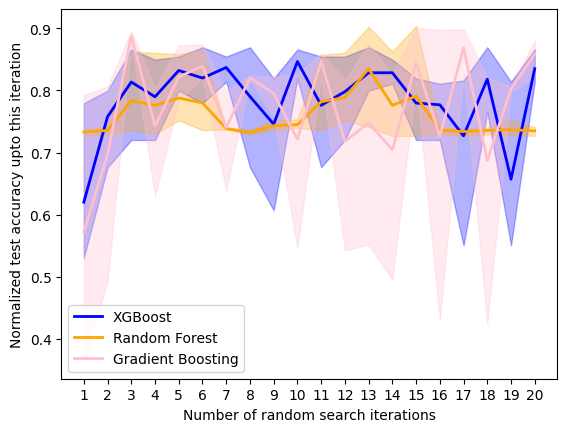

In [20]:
x = range(1, n_iterations+1)
plt.plot(x, clf_cat_xgboost_scores.mean(axis=0), label='XGBoost', color='blue', linewidth=2)
plt.plot(x, clf_cat_random_forest_scores.mean(axis=0), label='Random Forest', color='orange', linewidth=2)
plt.plot(x, clf_cat_gradient_boosting_scores.mean(axis=0), label='Gradient Boosting', color='pink', linewidth=2)

plt.fill_between(x, clf_cat_xgboost_scores.min(axis=0), clf_cat_xgboost_scores.max(axis=0), color='blue', alpha=0.3)
plt.fill_between(x, clf_cat_random_forest_scores.min(axis=0), clf_cat_random_forest_scores.max(axis=0), color='orange', alpha=0.3)
plt.fill_between(x, clf_cat_gradient_boosting_scores.min(axis=0), clf_cat_gradient_boosting_scores.max(axis=0), color='pink', alpha=0.3)

plt.xticks(x)
plt.ylabel('Normalized test accuracy upto this iteration')
plt.xlabel('Number of random search iterations')
plt.legend()
# plt.grid()